# Data Exploration and Preprocessing

 ### **Importing libraries**
Imports necessary libraries and modules for the deep learning model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

### **Data validation**


*   Iterating through image-mask pairs to check their dimensions.
*  Identifying and listing image and mask files that do not conform to the standard dimension (256x256).








In [ ]:

# Directories
base_directory = '/home/ubuntu/ForestSegmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')

# Load metadata
metadata_path = os.path.join(base_directory, 'meta_data.csv')
metadata = pd.read_csv(metadata_path)

# Lists to store file names with non-256x256 dimensions
non_standard_images = []
non_standard_masks = []

# Process each pair in the metadata
for _, row in metadata.iterrows():
    image_file = row['image']
    mask_file = row['mask']

    img_path = os.path.join(images_folder, image_file)
    mask_path = os.path.join(masks_folder, mask_file)

    # Read image and mask
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check for missing files
    if image is None or mask is None:
        print(f"Warning: Missing file - Image: {image_file}, Mask: {mask_file}")
        continue

    # Check dimensions and record if non-standard
    if image.shape[0] != 256 or image.shape[1] != 256:
        non_standard_images.append((image_file, image.shape))
    if mask.shape[0] != 256 or mask.shape[1] != 256:
        non_standard_masks.append((mask_file, mask.shape))

# Summary of results
print(f"Total pairs processed: {metadata.shape[0]}")
print(f"Non-standard image dimensions: {len(non_standard_images)}")
print(f"Non-standard mask dimensions: {len(non_standard_masks)}")

if non_standard_images:
    print("\nNon-standard Images:")
    for img, shape in non_standard_images:
        print(f"- {img} (Dimensions: {shape})")

if non_standard_masks:
    print("\nNon-standard Masks:")
    for mask, shape in non_standard_masks:
        print(f"- {mask} (Dimensions: {shape})")


Total pairs processed: 5108
Non-standard image dimensions: 0
Non-standard mask dimensions: 0


### **Setting Up Data Generators for Training**.

*  Splitting the Dataset into Train and Validation: It creates separate generators for training and validation subsets.
*   Rescaling Images : Images  are rescaled from a range of 0-255 to 0-1.

*  Image Dimension Specification: The target size for images and masks is set to 256x256 pixels.


In [ ]:
image_dimension = 256

image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15)
mask_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15)
data_path = '/home/ubuntu/ForestSegmented'

training_images_generator = image_data_generator.flow_from_directory(
        data_path,
        target_size=(image_dimension, image_dimension),
        class_mode=None,
        classes=['images'],
        batch_size=8,
        seed=42,
        subset='training')

training_masks_generator = mask_data_generator.flow_from_directory(
        data_path,
        target_size=(image_dimension, image_dimension),
        class_mode=None,
        classes=['masks'],
        color_mode='grayscale',
        batch_size=8,
        seed=42,
        subset='training')

validation_images_generator = image_data_generator.flow_from_directory(
        data_path,
        target_size=(image_dimension, image_dimension),
        class_mode=None,
        classes=['images'],
        batch_size=16,
        seed=42,
        subset='validation')

validation_masks_generator = mask_data_generator.flow_from_directory(
        data_path,
        target_size=(image_dimension, image_dimension),
        class_mode=None,
        classes=['masks'],
        color_mode='grayscale',
        batch_size=16,
        seed=42,
        subset='validation')

training_generator = zip(training_images_generator, training_masks_generator)
validation_generator = zip(validation_images_generator, validation_masks_generator)


Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


### **Data Visualization**.


*   Visualizing 10 sample images along with their corresponding masks from the data generators.

*   In the images, the yellow pixel regions represent the areas of interest, which are forest.
*   The output displays the original mask and an overlay with the original image.



<br />


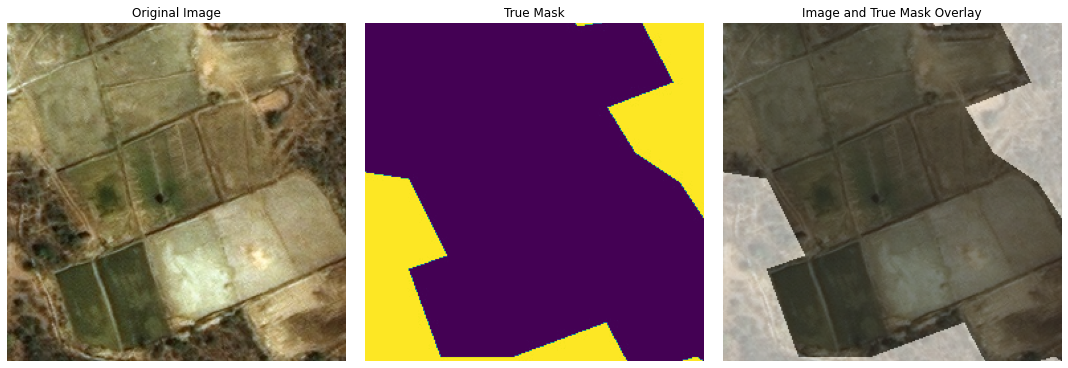

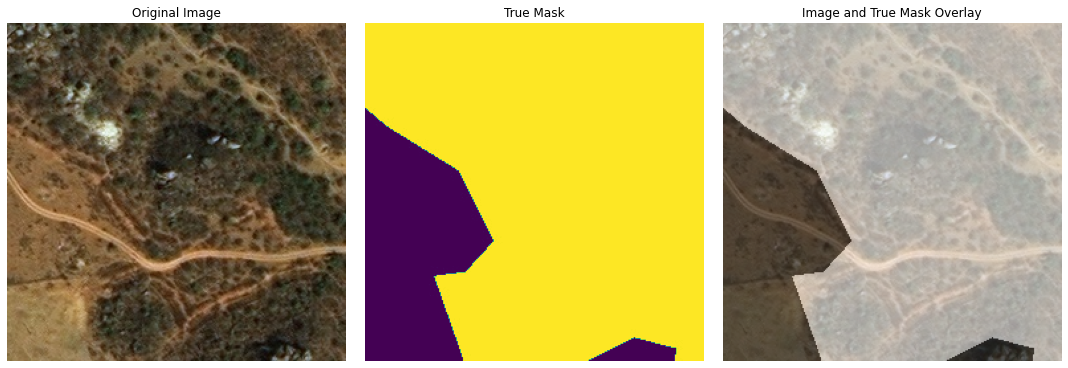

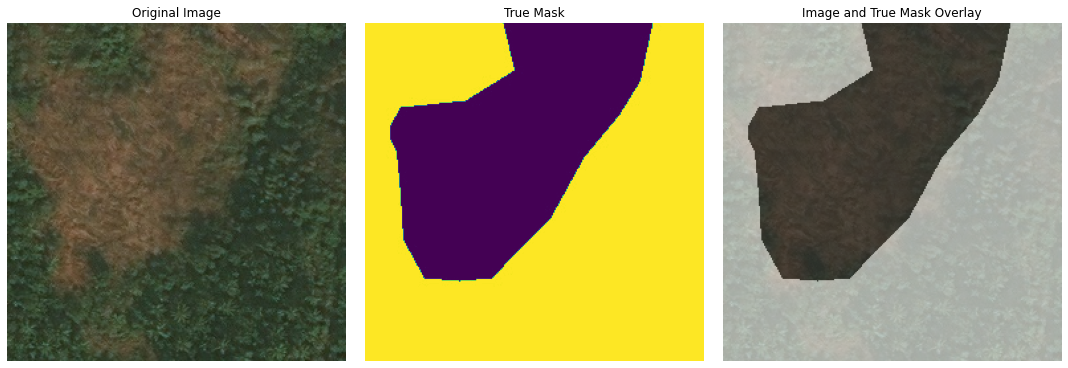

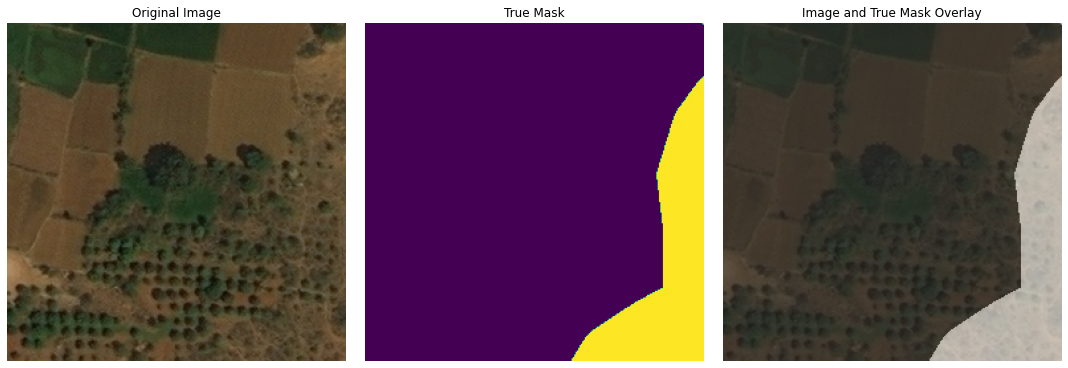

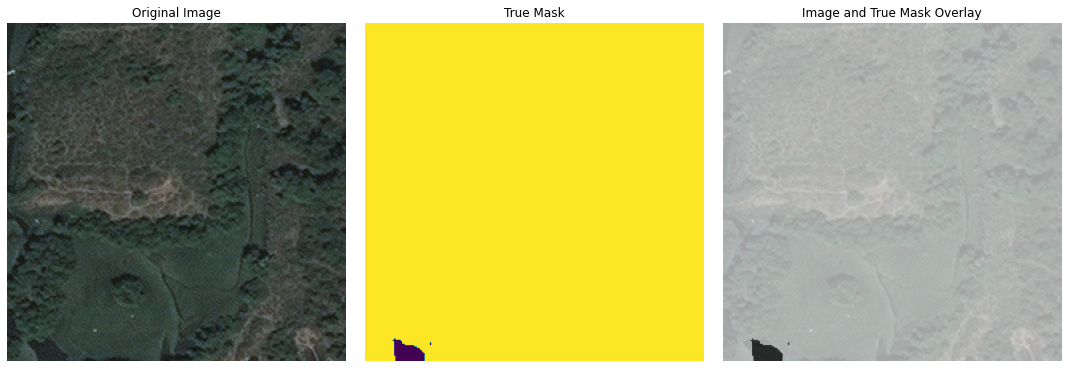

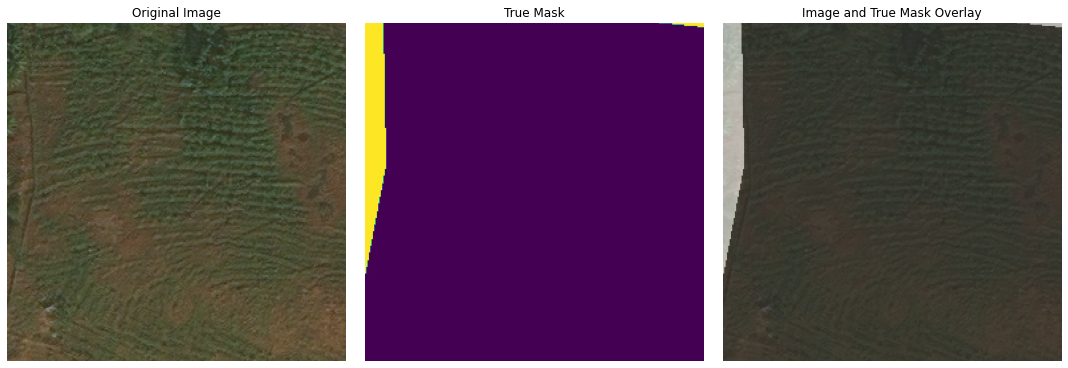

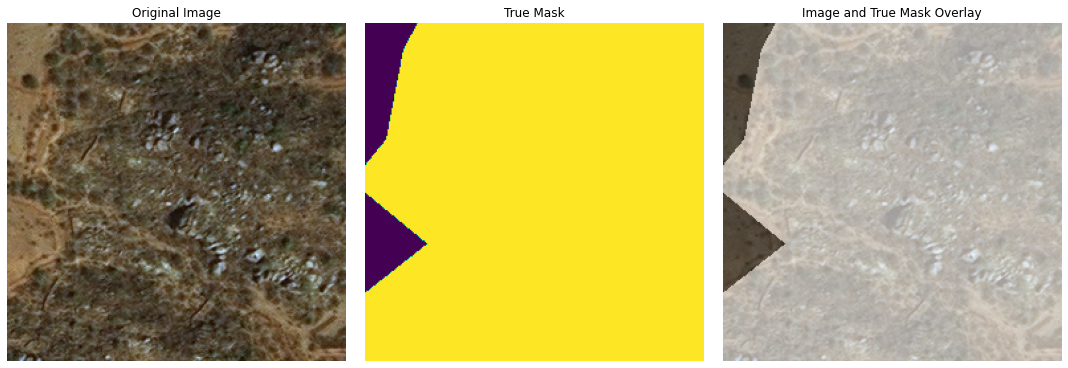

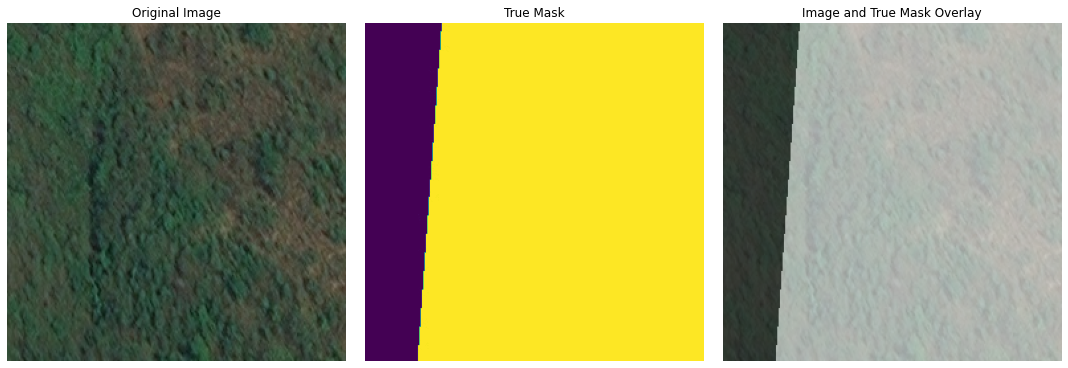

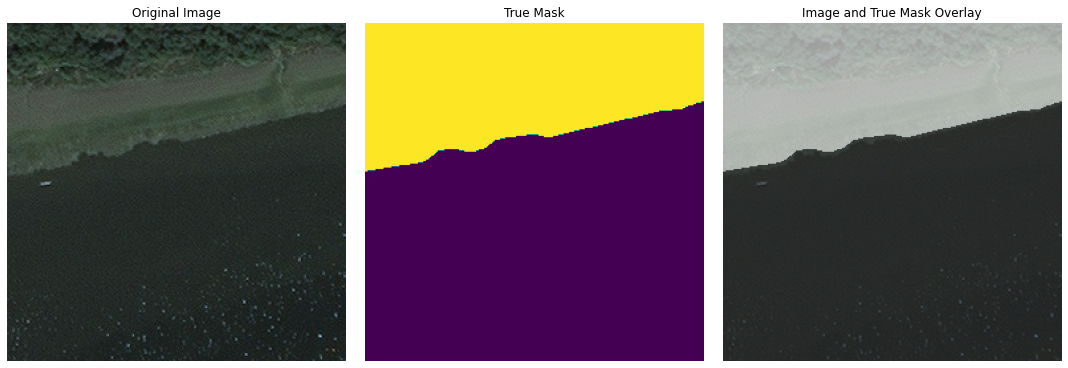

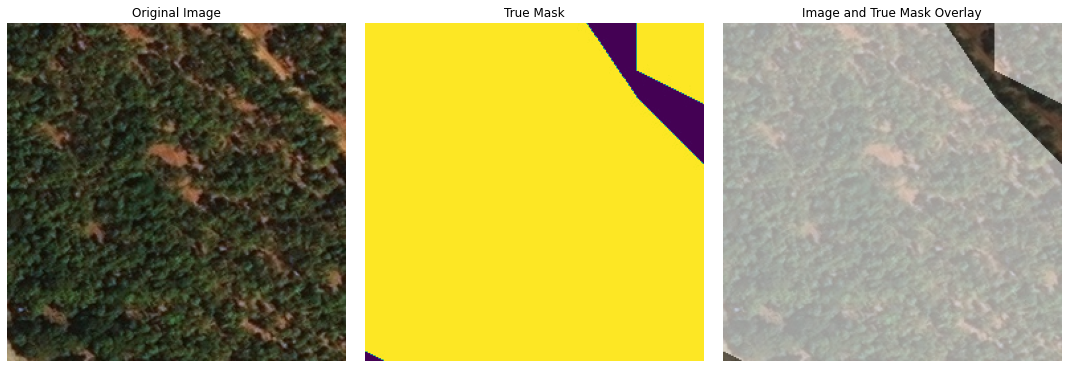

In [ ]:
import matplotlib.pyplot as plt

def show_images_and_masks_from_generator(image_generator, mask_generator, n_images=10, figsize=(25, 5), model=None,show_original=True):
    for _ in range(n_images):
        # Fetch a batch of images and masks

        images_batch = next(image_generator)
        masks_batch = next(mask_generator)
        batch_filenames = image_generator.filepaths

        # Plotting configuration
        plt.figure(figsize=figsize)
        n_cols = 3 if model is None else 5
        n_cols = 3 if show_original is None else 5

        # Plot the first image of the batch
        plt.subplot(1, n_cols, 1)
        plt.title("Original Image")
        plt.imshow(images_batch[0])
        plt.axis('off')

        if show_original:

        # Plot the first mask of the batch
            plt.subplot(1, n_cols, 2)
            plt.title("True Mask")
            plt.imshow(masks_batch[0].squeeze())
            plt.axis('off')

            # Plot image and true mask overlay
            plt.subplot(1, n_cols, 3)
            plt.title('Image and True Mask Overlay')
            plt.imshow(images_batch[0], alpha=0.8)  # Show the image first
            plt.imshow(masks_batch[0].squeeze(), alpha=0.5, cmap='binary_r')  # Overlay the true mask
            plt.axis('off')

        # Model predictions
        if model is not None:
            pred_mask = model.predict(tf.expand_dims(images_batch[0], axis=0))[0]
            pred_mask = pred_mask >= 0.5
            if np.all(pred_mask == 1):
                pred_mask[0, 0] = 0
            plt.subplot(1, n_cols, 4)
            plt.title('Predicted Mask')
            plt.imshow(pred_mask)
            plt.axis('off')

            plt.subplot(1, n_cols, 5)
            plt.title('Predicted Mask Overlay')
            plt.imshow(images_batch[0], alpha=0.8)  # Show the image first
            plt.imshow(pred_mask, alpha=0.5, cmap='binary_r')  # Overlay the predicted mask
            plt.axis('off')

        # Show final plot
        plt.tight_layout()
        plt.show()

show_images_and_masks_from_generator(validation_images_generator, validation_masks_generator, n_images=10, figsize=(25, 5), model=None)


# Model  Training

### **U-Net: Segmentation Architecture**
The data was trained on U-Net architecture, proposed in the 'U-Net: Convolutional Networks for Biomedical Image Segmentation' paper in 2015. [U-Net: Convolutional Networks for Biomedical Image Segmentation paper](https://arxiv.org/pdf/1505.04597.pdf).



**Architecture of the U-Net**  
<p align="center">
  <img src="https://blog.paperspace.com/content/images/size/w1000/2021/05/image-26.png" />
</p>

The encoder network is also called the contracting network. This network learns a feature map of the input image.
This encoder network consists of 4 encoder blocks. Each block contains two convolutional layers with a kernel size of 3*3 and valid padding, followed by a Relu activation function. This is inputted to a max pooling layer with a kernel size of 2*2. With the max pooling layer, we have halved the spatial dimensions learned, thereby reducing the computation cost of training the model.

In between the encoder and decoder network, we have the bottleneck layer. This is the bottommost layer, as we can see in the model above. It consists of 2 convolutional layers followed by Relu. The output of the bottleneck is the final feature map representation.

The decoder network is also called the expansive network. It is to upsample our feature maps to the size of our input image. This network takes the feature map from the bottleneck layer and generates a segmentation mask with the help of skip connections.It consists of 4 decoder blocks. Each block starts with a transpose convolution ( indicated as up-conv in the diagram) with a kernel size of 2*2. This output is concatenated with the corresponding skip layer connection from the encoder block. After which, two convolutional layers with a kernel size of 3*3 are used, followed by a Relu activation function.

Skip connections are indicated with a grey arrow in the model architecture. Skip connections help us use the contextual feature information collected in the encoder blocks to generate our segmentation map.

A 1*1 convolution follows the last decoder block with sigmoid activation which gives the output of a segmentation mask containing pixel-wise classification. This way, it could be said that the contracting path passes across information to the expansive path. And thus, we can capture both the feature information and localization with the help of a U-Net.

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (image_dimension, image_dimension, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
training_samples_size = training_images_generator.samples
val_samples_size = validation_images_generator.samples
print(training_samples_size)
print(val_samples_size)

4342
766


### **Metrics to Evaluate**:

*  IoU (Intersection over Union): IoU calculates the overlap between predicted segmentation and the ground truth, divided by the union of these two areas. It's a direct measure of how well the predicted segmentation fits the actual ground truth.
*  Precision: Measures the proportion of true positive predictions in the total predicted positives. High precision indicates a low rate of false positives.
*  Recall: Assesses the proportion of actual positives correctly identified by the model. High recall indicates a low rate of false negatives.





In [ ]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,
        'accuracy',tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

### **Training the model**


* The model is trained with a batch size of 8.
*  The training is set to run for 25 epochs.



In [ ]:
model_history = model.fit(training_generator,
                    steps_per_epoch=training_samples_size//8,
                    validation_data=validation_generator,
                    validation_steps=val_samples_size//16,
                    epochs=25, callbacks=[earlystop, checkpoint])

Epoch 1/25
542/542 [==============================] - ETA: 0s - loss: 0.4447 - iou_coef: 0.5501 - accuracy: 0.7933 - precision: 0.8150 - recall: 0.8768
Epoch 00001: val_loss improved from inf to 0.57963, saving model to unet.h5
542/542 [==============================] - 407s 750ms/step - loss: 0.4447 - iou_coef: 0.5501 - accuracy: 0.7933 - precision: 0.8150 - recall: 0.8768 - val_loss: 0.5796 - val_iou_coef: 0.4741 - val_accuracy: 0.7155 - val_precision: 0.8051 - val_recall: 0.7419
Epoch 2/25
542/542 [==============================] - ETA: 0s - loss: 0.4485 - iou_coef: 0.5489 - accuracy: 0.7908 - precision: 0.8137 - recall: 0.8744
Epoch 00002: val_loss did not improve from 0.57963
542/542 [==============================] - 403s 743ms/step - loss: 0.4485 - iou_coef: 0.5489 - accuracy: 0.7908 - precision: 0.8137 - recall: 0.8744 - val_loss: 0.6189 - val_iou_coef: 0.4338 - val_accuracy: 0.6884 - val_precision: 0.8412 - val_recall: 0.6350
Epoch 3/25
542/542 [==============================]

Epoch 19/25
542/542 [==============================] - ETA: 0s - loss: 0.3992 - iou_coef: 0.5778 - accuracy: 0.8157 - precision: 0.8381 - recall: 0.8844
Epoch 00019: val_loss did not improve from 0.38761
542/542 [==============================] - 403s 743ms/step - loss: 0.3992 - iou_coef: 0.5778 - accuracy: 0.8157 - precision: 0.8381 - recall: 0.8844 - val_loss: 0.4043 - val_iou_coef: 0.6368 - val_accuracy: 0.8238 - val_precision: 0.8388 - val_recall: 0.9131
Epoch 20/25
542/542 [==============================] - ETA: 0s - loss: 0.3961 - iou_coef: 0.5825 - accuracy: 0.8192 - precision: 0.8458 - recall: 0.8812
Epoch 00020: val_loss did not improve from 0.38761
542/542 [==============================] - 402s 742ms/step - loss: 0.3961 - iou_coef: 0.5825 - accuracy: 0.8192 - precision: 0.8458 - recall: 0.8812 - val_loss: 0.4043 - val_iou_coef: 0.6137 - val_accuracy: 0.8188 - val_precision: 0.8283 - val_recall: 0.9210
Epoch 21/25
542/542 [==============================] - ETA: 0s - loss: 0.3

### **Training Learning Curve**

*  Based on the graph, the validation loss did not improve beyond epoch 18.


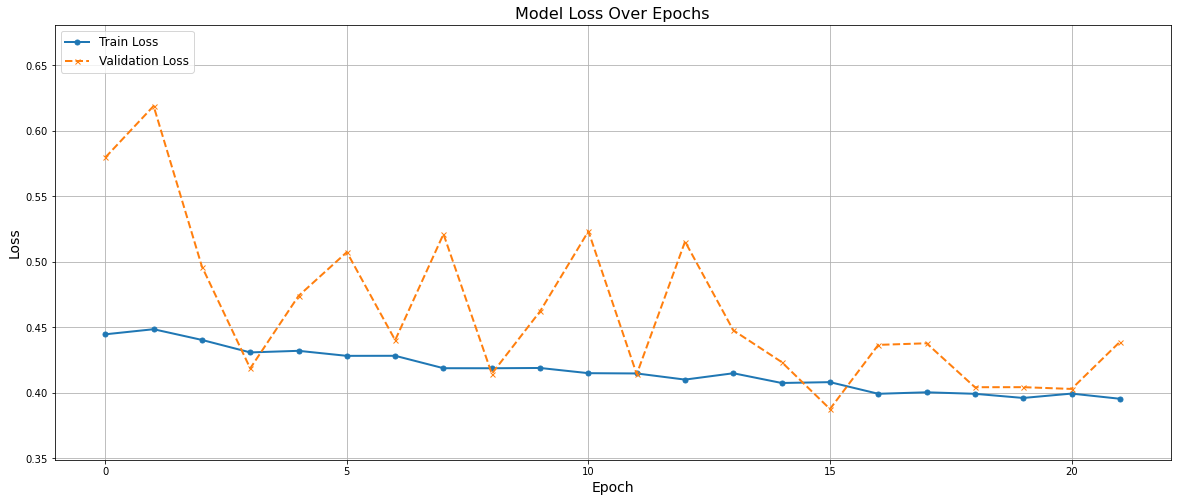

In [ ]:
plt.figure(figsize=(20, 8))

# Plotting
plt.plot(model_history.history['loss'], linestyle='-', linewidth=2, marker='o', markersize=5)
plt.plot(model_history.history['val_loss'], linestyle='--', linewidth=2, marker='x', markersize=5)


plt.title('Model Loss Over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.grid(True)
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left', fontsize=12)

# Dynamic Y-Limit
plt.ylim([min(min(model_history.history['loss']), min(model_history.history['val_loss'])) * 0.9,
          max(max(model_history.history['loss']), max(model_history.history['val_loss'])) * 1.1])



# Save the figure (Optional)
# plt.savefig('model_loss_plot.png')

plt.show()


# Segmentation and Analysis

###  **Performing inference on the model.**





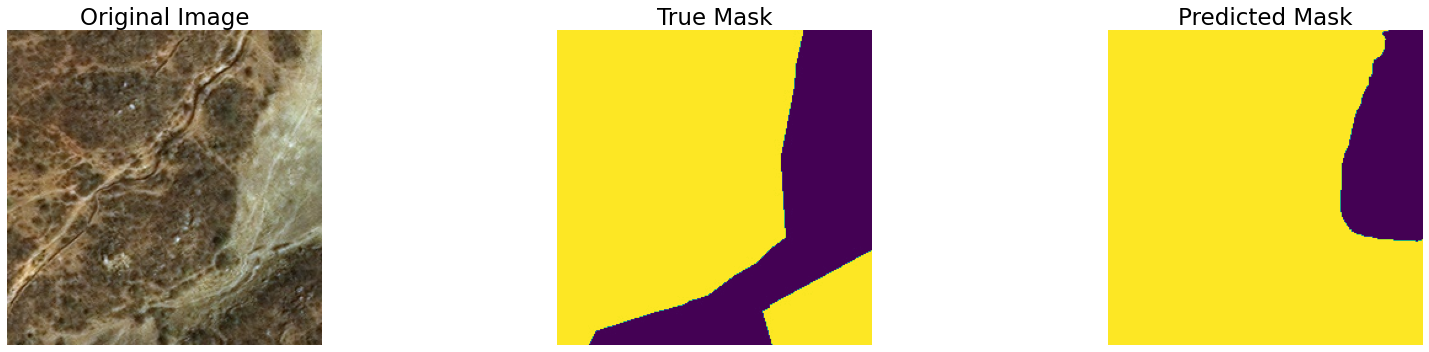

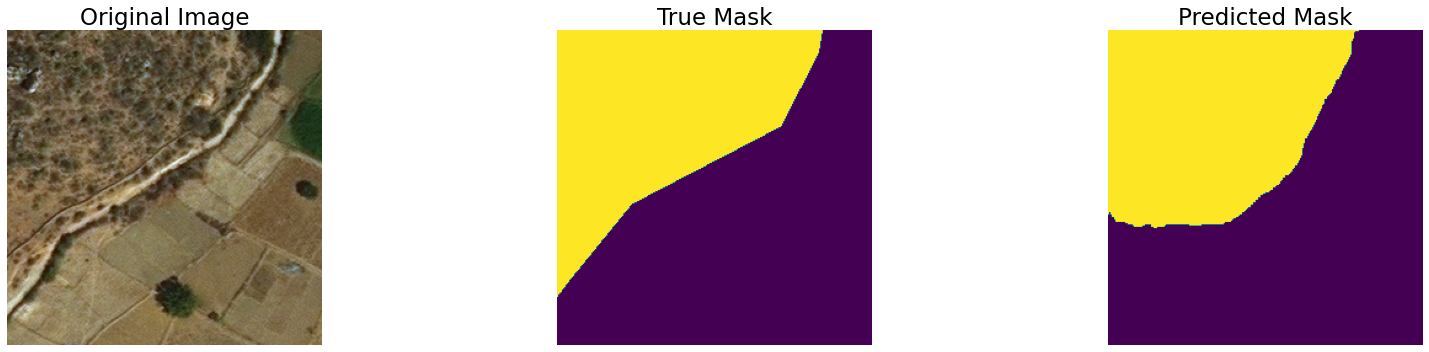

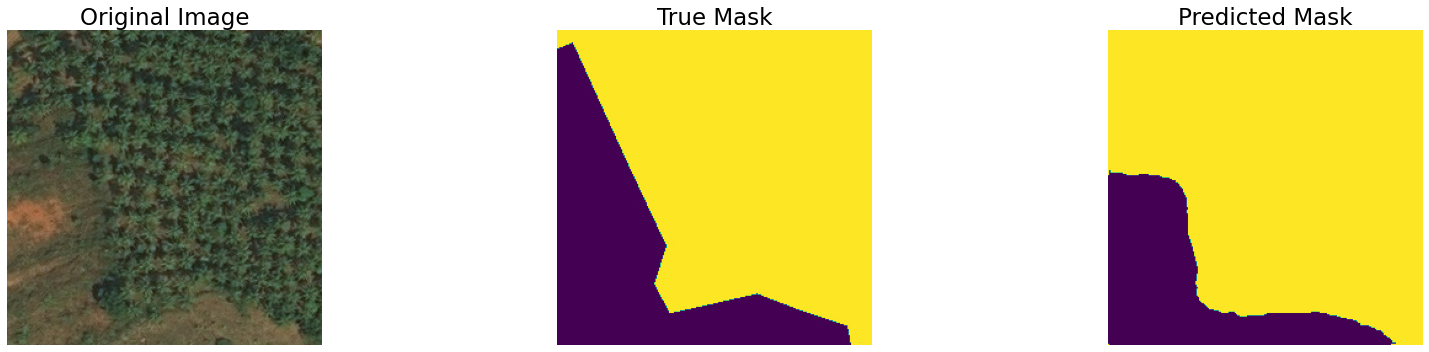

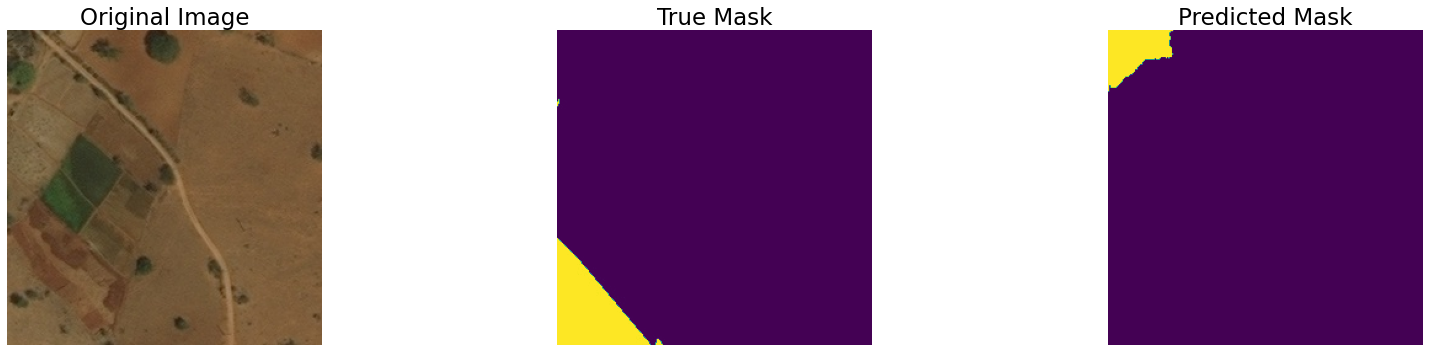

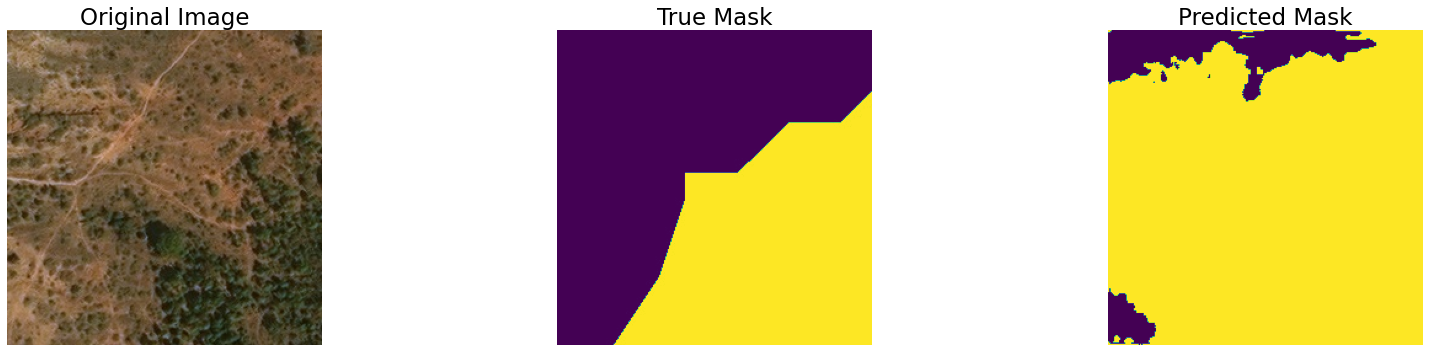

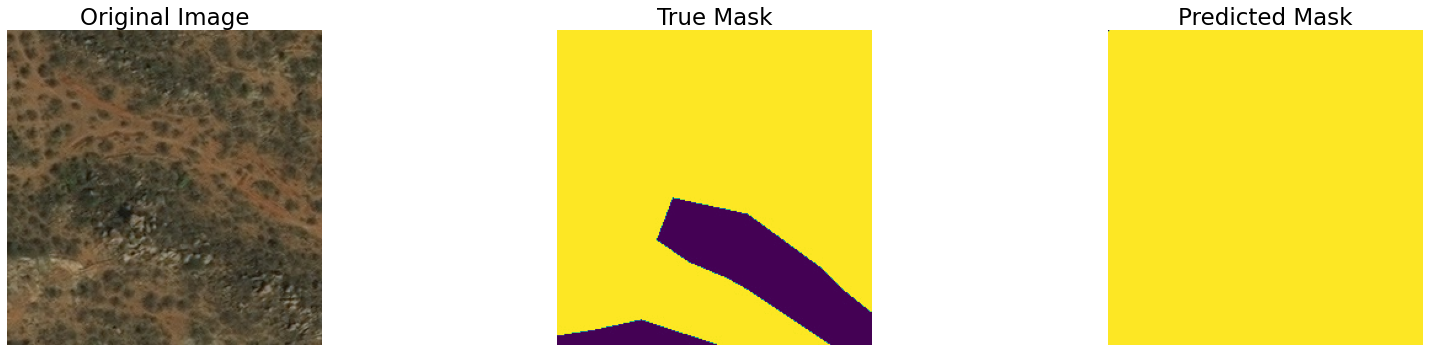

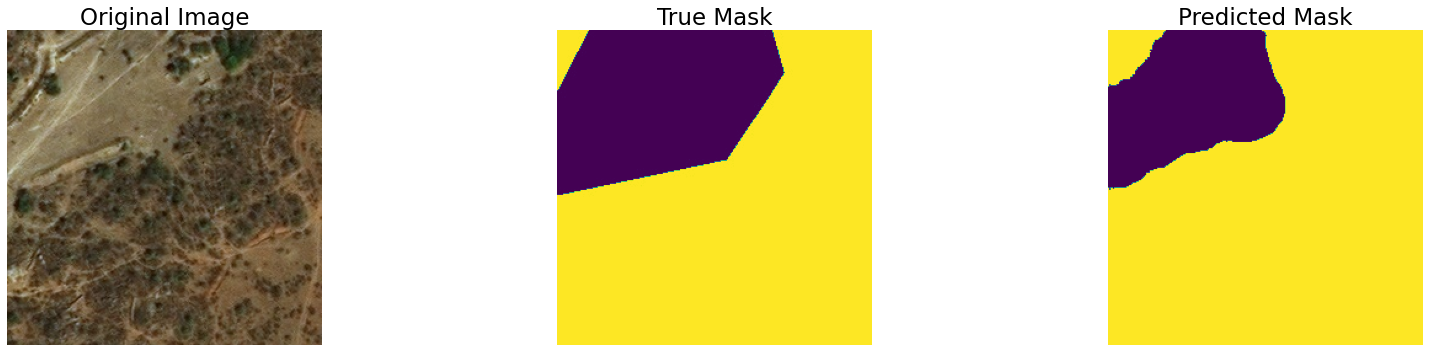

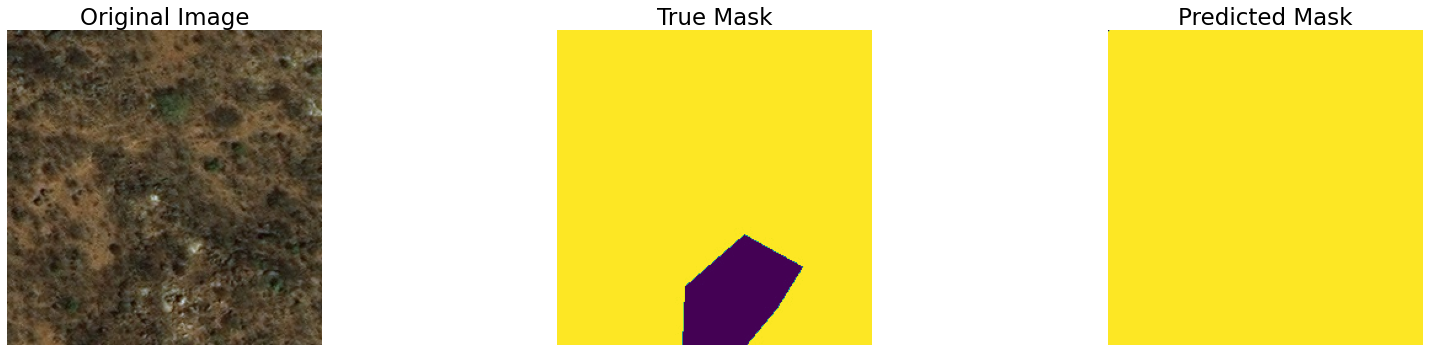

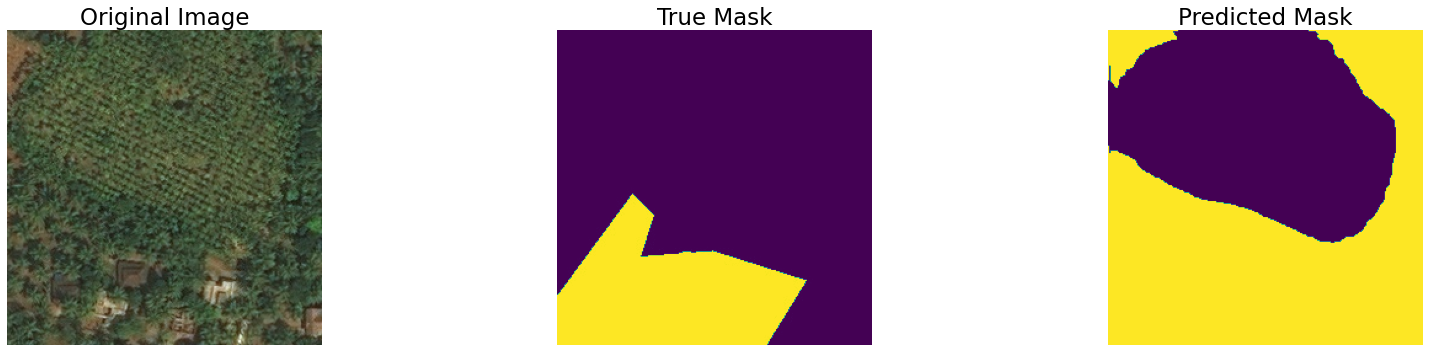

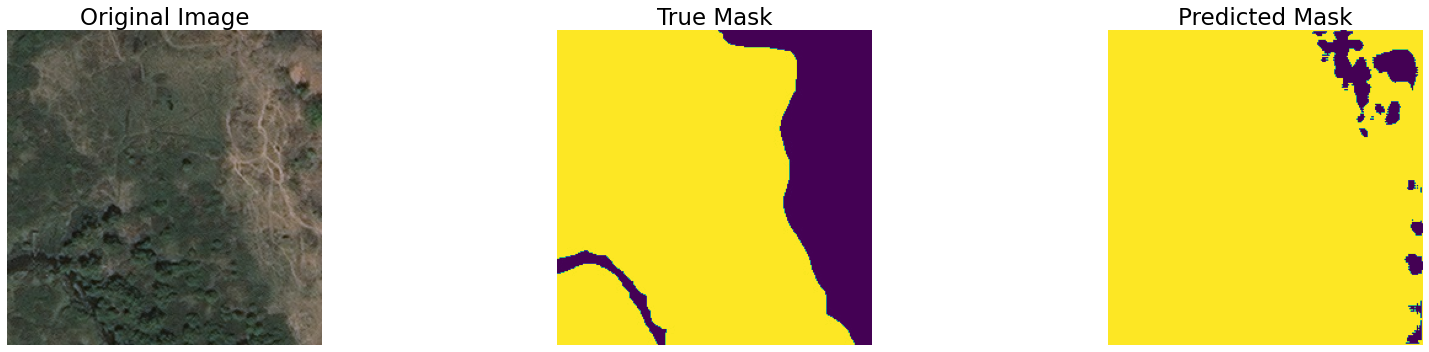

In [ ]:
import matplotlib.pyplot as plt

def pred_images_and_masks_from_generator(image_generator, mask_generator, n_images=10, figsize=(25, 5), model=None,show_original=True):
    for _ in range(n_images):
        # Fetch a batch of images and masks

        images_batch = next(image_generator)
        masks_batch = next(mask_generator)
        batch_filenames = image_generator.filepaths

        # Plotting configuration
        plt.figure(figsize=figsize)
        n_cols = 3

        # Plot the first image of the batch
        plt.subplot(1, n_cols, 1)
        plt.title("Original Image",fontsize=23)
        plt.imshow(images_batch[0])
        plt.axis('off')

        if show_original:

        # Plot the first mask of the batch
            plt.subplot(1, n_cols, 2)
            plt.title("True Mask",fontsize=23)
            plt.imshow(masks_batch[0].squeeze())
            plt.axis('off')




        if model is not None:
            pred_mask = model.predict(tf.expand_dims(images_batch[0], axis=0))[0]
            pred_mask = pred_mask >= 0.5
            if np.all(pred_mask == 1):
                pred_mask[0, 0] = 0
            plt.subplot(1, n_cols, 3)
            plt.title('Predicted Mask',fontsize=23)
            plt.imshow(pred_mask)
            plt.axis('off')


        # Show final plot
        plt.tight_layout()
        plt.show()

pred_images_and_masks_from_generator(validation_images_generator, validation_masks_generator, n_images=10, figsize=(25, 5), model=model)



### **comparison with original mask and predicted with overlay on original**

*   Visualizing 10 sample images from validation dataset
*  The output displays the original mask, the predicted mask, and an overlay with the original image.



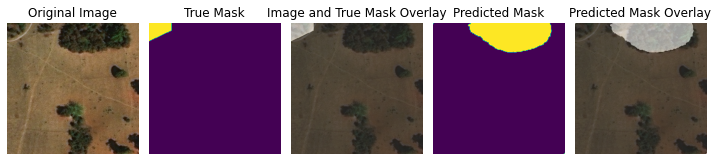

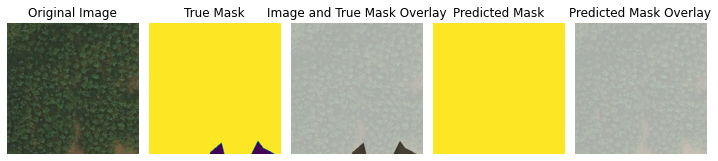

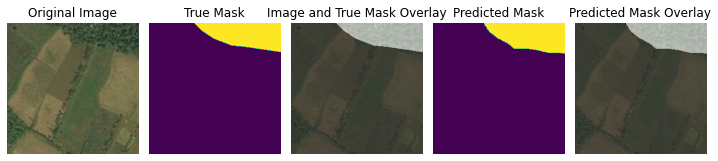

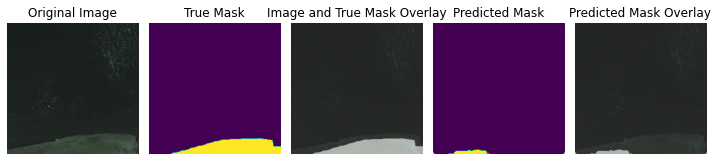

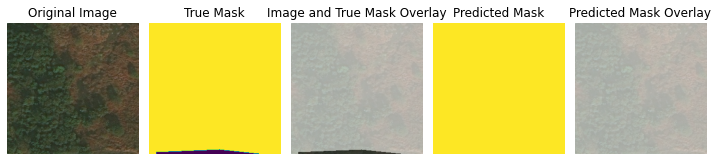

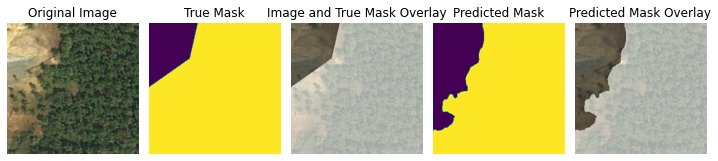

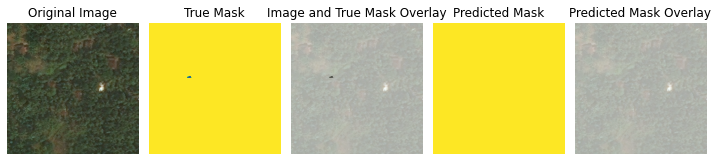

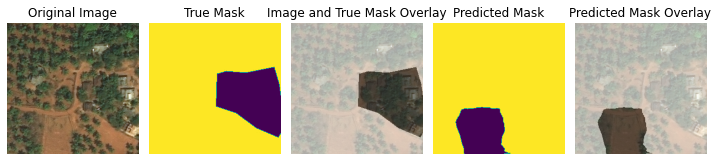

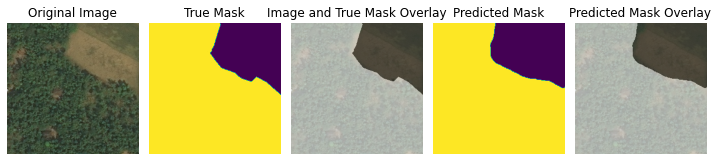

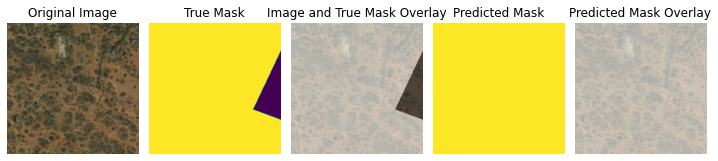

In [ ]:

show_images_and_masks_from_generator(validation_images_generator, validation_masks_generator, n_images=10, figsize=(10, 5), model=model)


# Conclusion
The model's predictions, at times, were more accurate than the original labels in identifying forests. Labeling inconsistencies complicate the evaluation of the model's efficiency.  Due to imprecise annotations in labeling forests, assessing the model's true accuracy becomes challenging.In computer vision, the quality of data and annotations is crucial; flawed data can limit the performance of the best models. Hence, correcting the labels will undoubtedly enhance the model's accuracy, leading to more precise and reliable results.


